In [1]:
import sys
sys.path.append('../')
from illustris_frb import frb_simulation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import healpy as hp
from astropy import units as u

figpath = '/ceph/submit/data/group/submit-illustris/april/data/figures'
gcat_dir = '/ceph/submit/data/group/submit-illustris/april/data/g_cats'

In [3]:
origin = 500 * np.array([50, 70, 23])
sim = frb_simulation(origin=origin)

z = 0.4
x = sim.comoving_distance(z)

In [42]:
# compute angular size of a bin at z = 0.4, in rad
bin_ang = sim.binsize / (sim.cosmo.angular_diameter_distance(z).to(u.kpc).value * sim.h)
print(f'Angular size of {sim.binsize} ckpc/h bin at z={z}: {bin_ang:.5f} rad = {np.degrees(bin_ang)*60:.2f}\'')

Angular size of 500 ckpc/h bin at z=0.4: 0.00065 rad = 2.22'


In [53]:
# compute angular size of a bin at z = 0.4, in rad
bin_ang = sim.binsize / (sim.cosmo.angular_diameter_distance(0.2).to(u.kpc).value * sim.h)
print(f'Angular size of {sim.binsize} ckpc/h bin at z=0.2: {bin_ang:.5f} rad = {np.degrees(bin_ang)*60:.2f}\'')

Angular size of 500 ckpc/h bin at z=0.2: 0.00105 rad = 3.61'


## Constraint #1: A ray cannot cross the same region twice 

The bad rays are ones that are an integer multiple of the simulation box size. Therefore, we have to think about all integer vectors with $|\vec{v}| \leq \frac{x}{\mathrm{boxsize}}$, where $x$ is the distance between the source and origin. We can do this via:

In [4]:
def get_bad_vecs(z, boxsize=sim.boxsize):

    x = sim.comoving_distance(z)
    
    n = int(np.ceil(x/boxsize))
    vecs = np.indices((2*n+1, 2*n+1, 2*n+1)).reshape((3, (2*n+1)**3)).T - n # integer vecs in cube
    vecs = vecs[ np.any(vecs, axis=1) ] # get rid of (0,0,0)
    
    gcd = np.gcd(np.gcd(vecs[:,0], vecs[:,1]), vecs[:,2])
    vecs = np.unique(np.floor_divide(vecs.T, gcd).T, axis=0) # get rid of vectors that point in the same direction
    
    return vecs[ (norm(vecs, axis=1) <= x/boxsize) ] 

Resolution: 55.0'


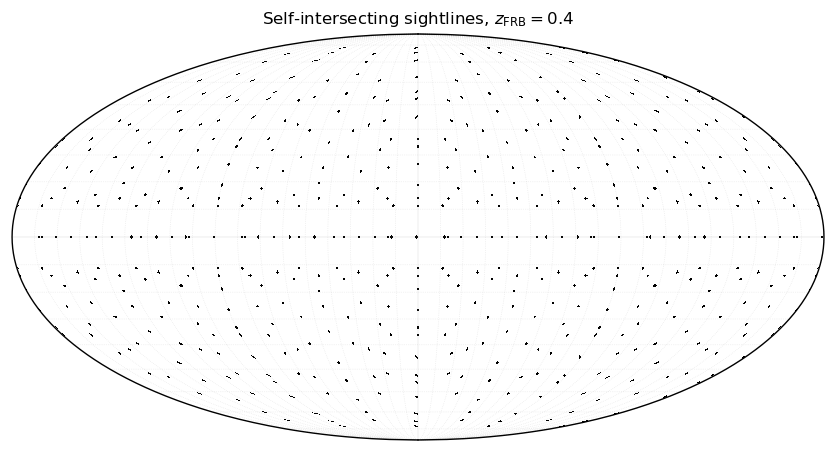

In [5]:
nside = 64
print(f"Resolution: {hp.nside2resol(nside, arcmin=True):.1f}\'")

npix = hp.nside2npix(nside)

bad_vecs = get_bad_vecs(0.4) # visualize bad points for z=0.4

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z04 = np.ones(npix)
goodpix_1_z04[ bad_pixels ] = 0

hp.mollview(goodpix_1_z04, title=r'Self-intersecting sightlines, $z_{\mathrm{FRB}} = 0.4$', cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.2)
# plt.savefig(os.path.join(figpath, 'bad_pixels_1_z04.pdf'), dpi=250)

Resolution: 27.5'


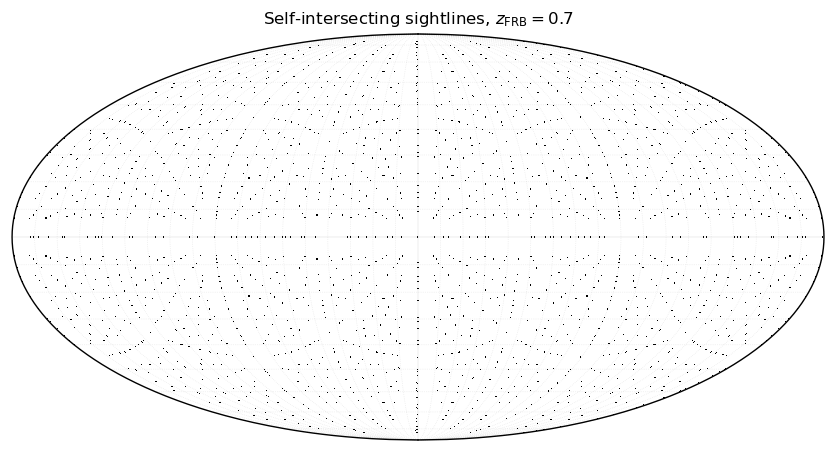

In [7]:
nside = 128
print(f"Resolution: {hp.nside2resol(nside, arcmin=True):.1f}\'")

npix = hp.nside2npix(nside)

bad_vecs = get_bad_vecs(0.7)

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z07 = np.ones(npix)
goodpix_1_z07[ bad_pixels ] = 0

hp.mollview(goodpix_1_z07, title=r'Self-intersecting sightlines, $z_{\mathrm{FRB}} = 0.7$', cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.2)
plt.savefig(os.path.join(figpath, 'bad_pixels_1_z07.pdf'), dpi=250)

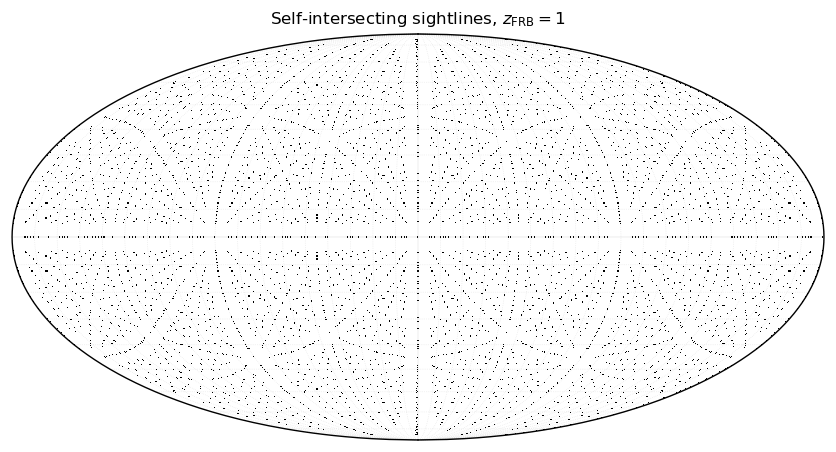

In [8]:
bad_vecs = get_bad_vecs(1)

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z1 = np.ones(hp.nside2npix(nside))
goodpix_1_z1[ bad_pixels ] = 0

hp.mollview(goodpix_1_z1, title=r'Self-intersecting sightlines, $z_{\mathrm{FRB}} = 1$', cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.2)
plt.savefig(os.path.join(figpath, 'bad_pixels_1_z1.pdf'), dpi=250)

# Constraint #2: Adjacent rays should not encounter the same structures in different boxes 

Consider the ray going from the origin to the center of the sky region of interest. This ray, repeated in stacked periodic boxes, represents lines (images) that cannot not be crossed. Previously, we imposed the constraint that the ray cannot intersect its own images. Now, we introduce the constraint that nearby rays within the sky region also cannot cross this image, since that introduces spatial correlations dependent on the geometry of the configuration.

For a sightline $\vec{v}$, the distance between $\vec{v}$ and an adjacent image $\vec{v} + \vec{u}$ is $d = \hat{v} \times \vec{u}$. Here, $\vec{u}$ is a vector describing an adjacent box, i.e. an integer multiple of the box size. Therefore, the sky region cannot subtend more than $d / d_A$.

In [6]:
def get_d(v, s=sim.boxsize): # distance to nearest sightline image
    vhat = np.abs(v)/np.atleast_2d(norm(np.atleast_2d(v), axis=1)).T
    dists = []
    for check in np.mgrid[0:2, 0:2, 0:2].T.reshape(8,3)[1:]:
        dists.append(norm(np.atleast_2d(np.cross(vhat, check)), axis=1))
    res = s*np.amin(np.vstack(dists), axis=0)
    if v.ndim < 2:
        return res[0]
    return res

def get_max_regsize(v, z):
    return get_d(v) / ( sim.cosmo.angular_diameter_distance(z).to(u.kpc).value * sim.h )

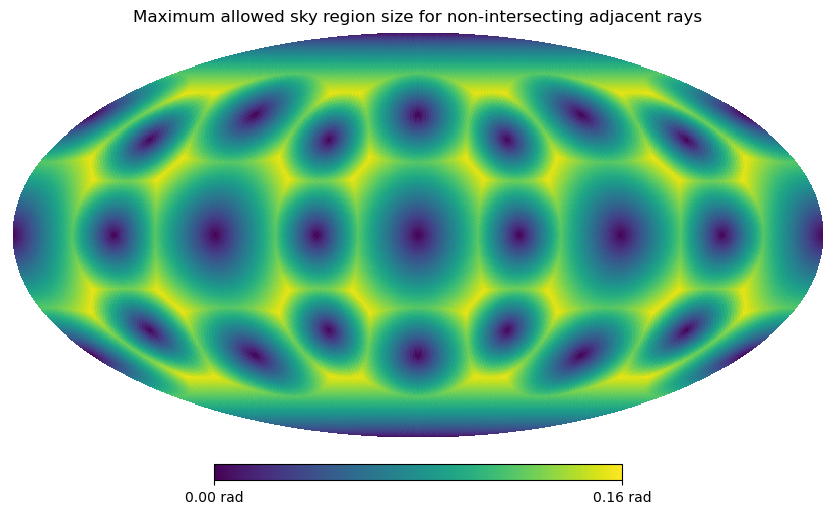

In [7]:
# visualize range of allowed sky regions

pixels = np.arange(npix)

vecs = np.vstack(hp.pix2vec(nside=nside, ipix=pixels)).T
sizes = get_max_regsize(vecs, z=0.4)

hp.mollview(sizes, title="Maximum allowed sky region size for non-intersecting adjacent rays", min=0, max=0.16, format='%.2f rad')
# plt.savefig(os.path.join(figpath, 'allowed_skyreg_size_2.pdf'), dpi=250, bbox_inches='tight')

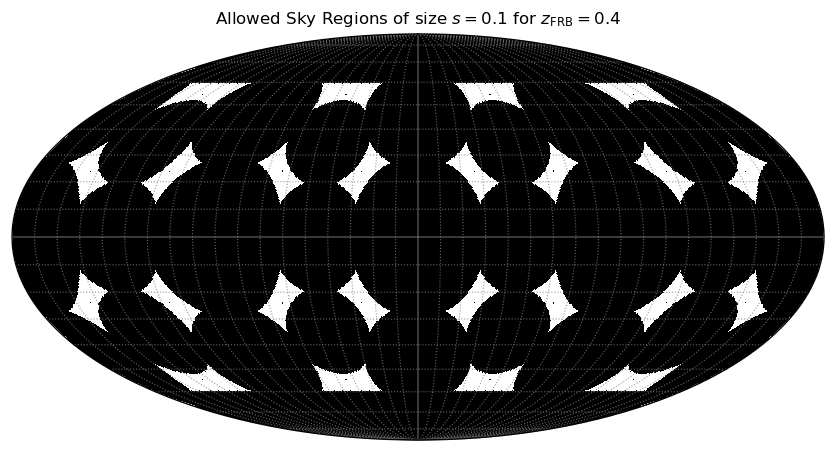

In [11]:
# overplot with constraint #1, for region size a=0.1
z, a = 0.4, 0.094

#recompute constraint 1
nside = 128
npix = hp.nside2npix(nside)

bad_vecs = get_bad_vecs(z) 
bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z04 = np.ones(npix)
goodpix_1_z04[ bad_pixels ] = 0

#compute constraint 2
pixels = np.arange(npix)
vecs = np.vstack(hp.pix2vec(nside=nside, ipix=pixels)).T
sizes = get_max_regsize(vecs, z=0.4)

goodpix_2 = sizes > np.sqrt(2)*a

hp.mollview(goodpix_1_z04 * goodpix_2, title=r"Allowed Sky Regions of size $s = 0.1$ for $z_{\mathrm{FRB}} = 0.4$", cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.8, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allowed_sky_regions_z04_10.pdf'), dpi=250, bbox_inches='tight')

## finding regions manually 

In [9]:
from illustris_frb import region

In [10]:
def plotregion(k, theta, dphi): #in degrees, for z=0.4, 0.1x0.1 rad region
    reg = region(k, theta, dphi)

    centers = np.arange(-reg.size/2+reg.res/2, reg.size/2, reg.res) 
    thetas_, phis_ = np.meshgrid(np.pi/2 + centers, centers)
    thetas, phis = reg.rotate(thetas_.T.flatten(), phis_.T.flatten())
    
    ipix = np.unique(hp.ang2pix(nside, thetas, phis))
    regionpix = goodpix_1_z04 * goodpix_2 # good pixels found previously
    regionpix[ ipix ] = 0.5

    hp.mollview(regionpix, title=None, cmap=plt.colormaps['Grays'].reversed(), cbar=False)

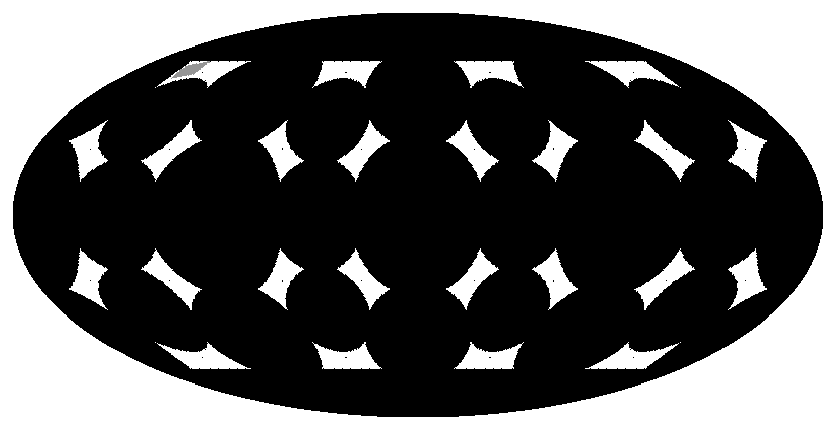

In [23]:
# start with upper left, go across
# region A1
plotregion((1.18, -np.pi/2), 1.11, 1.88)

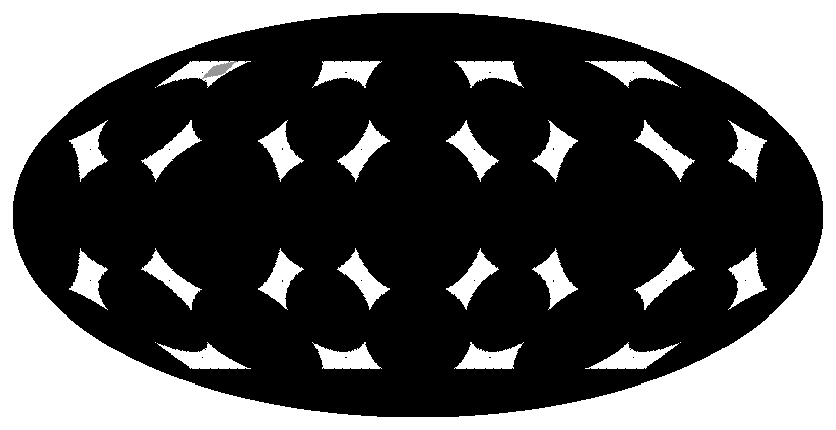

In [24]:
#region A2
plotregion((1.18, -np.pi/2), 1.11, 1.56)

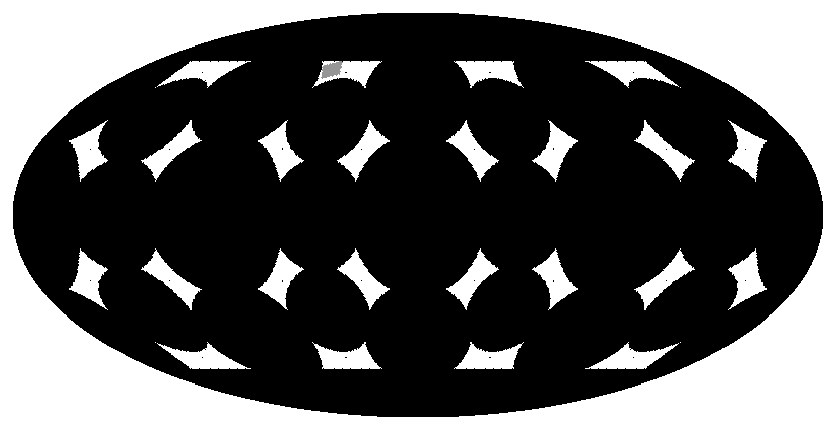

In [25]:
plotregion((1.18, -np.pi/2), 1.11, 0.31)

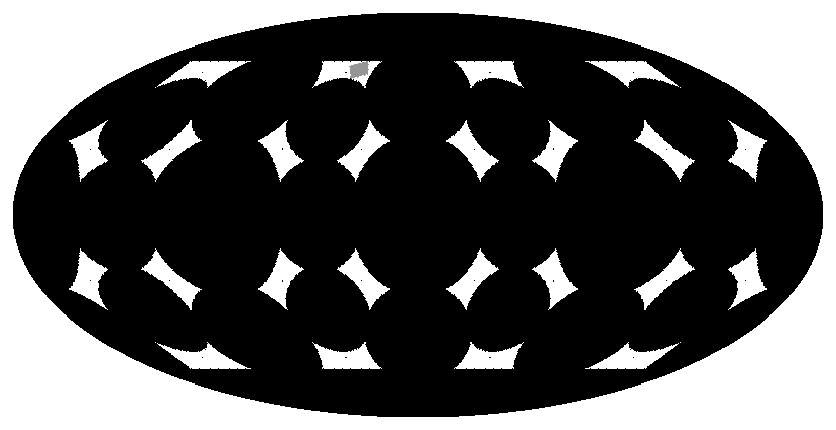

In [26]:
plotregion((1.18, -np.pi/2), 1.11, 0)

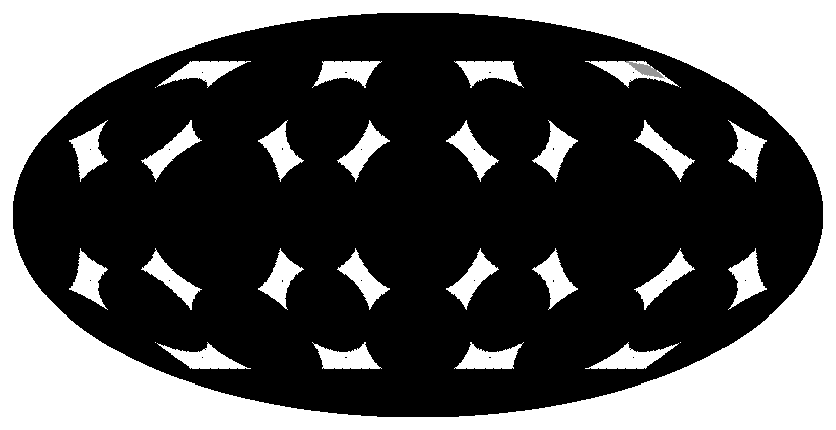

In [27]:
plotregion((1.18, np.pi/2), -1.11, -1.88) #reflect A1 to get A8

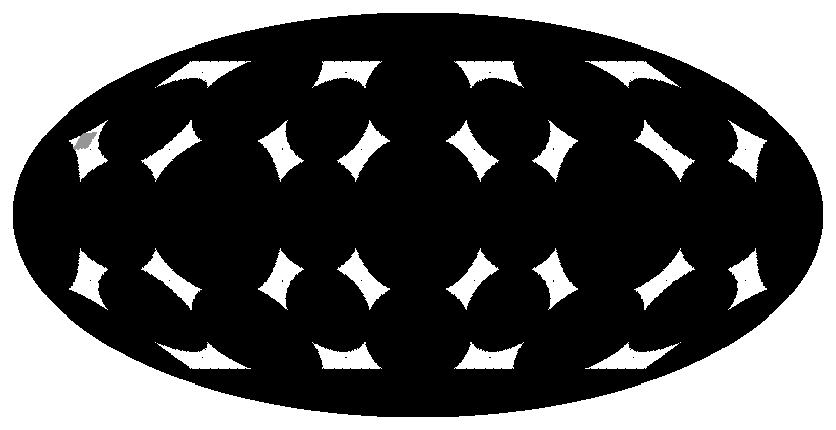

In [28]:
# B1
plotregion((0.94, -np.pi/2), 0.6, 2.39)

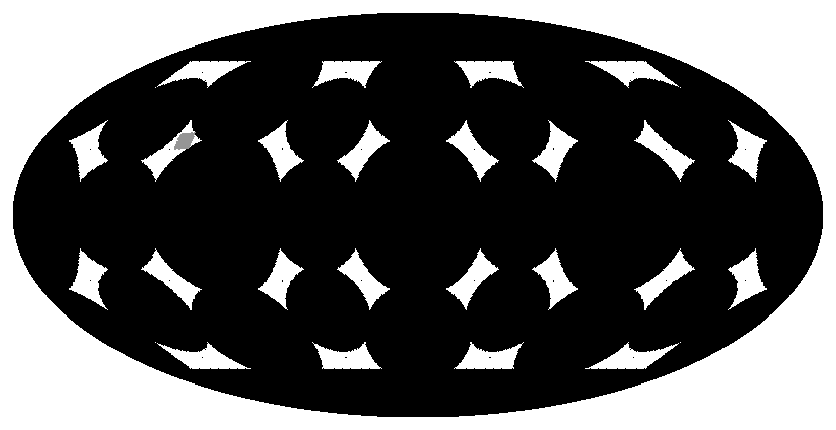

In [29]:
# B2
plotregion((0.94, -np.pi/2), 0.6, 1.56)

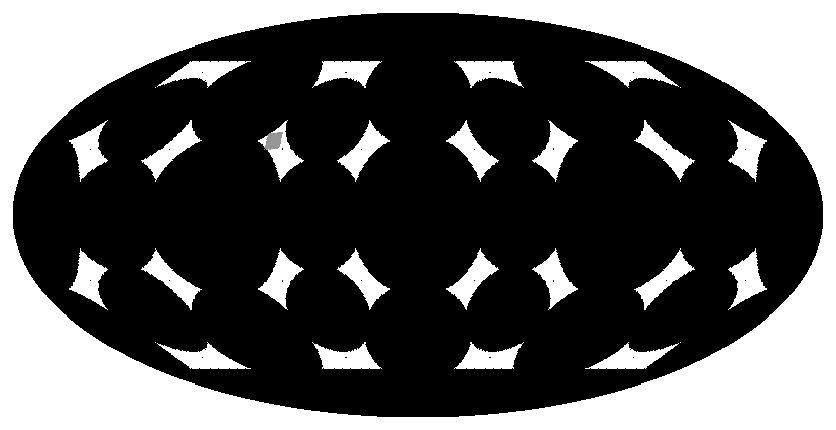

In [30]:
# B3
plotregion((0.94, -np.pi/2), 0.6, 0.82)

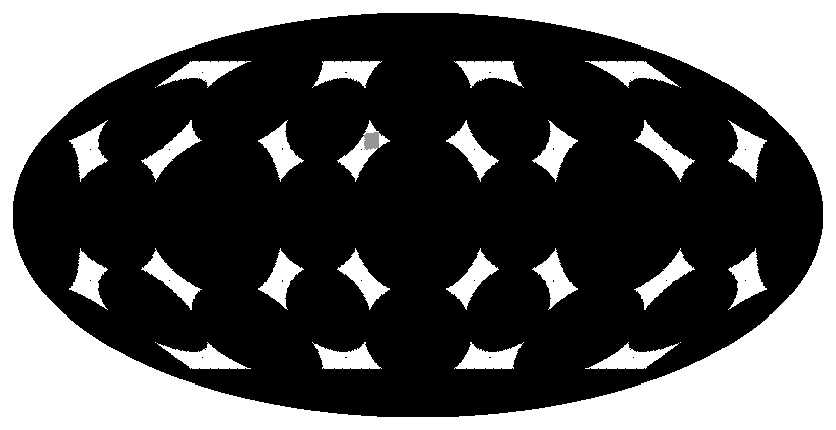

In [31]:
# B4
plotregion((0.94, -np.pi/2), 0.6, 0)

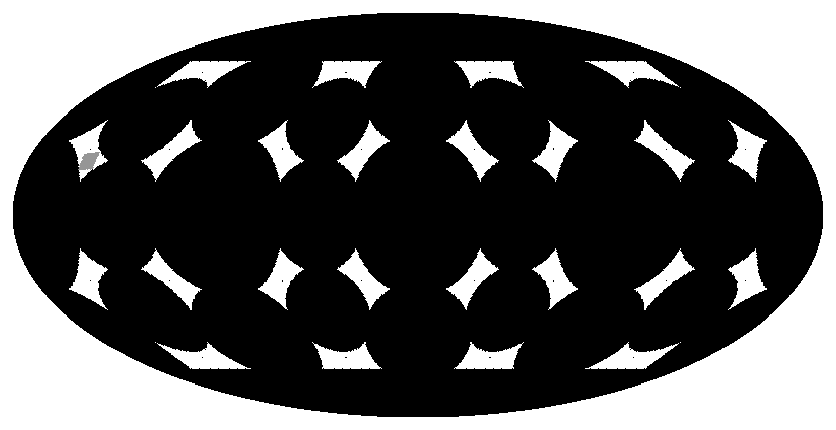

In [32]:
# C1
plotregion((0.63, -np.pi/2), 0.6, 2.14)

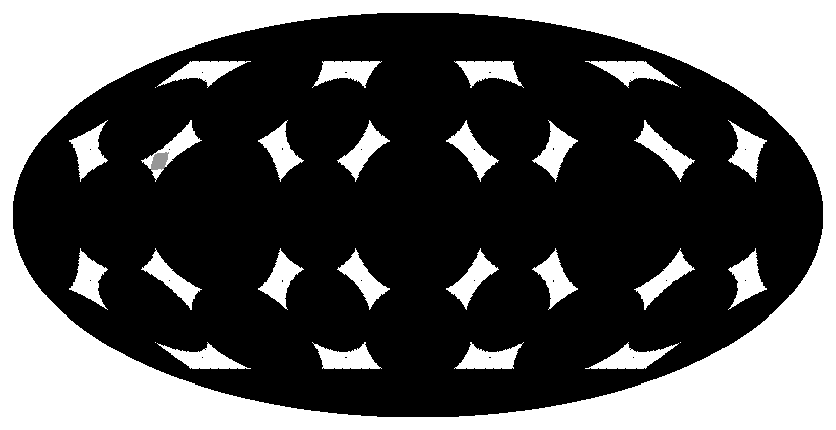

In [33]:
# C2
plotregion((0.63, -np.pi/2), 0.6, 1.57)

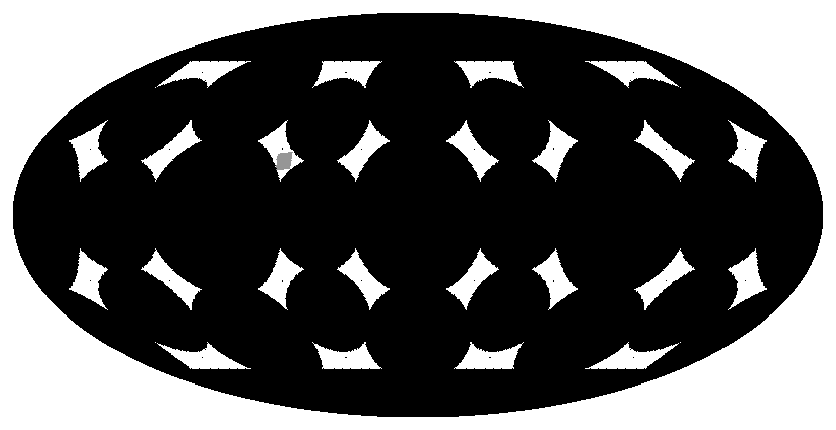

In [34]:
# C3
plotregion((0.63, -np.pi/2), 0.6, 0.57)

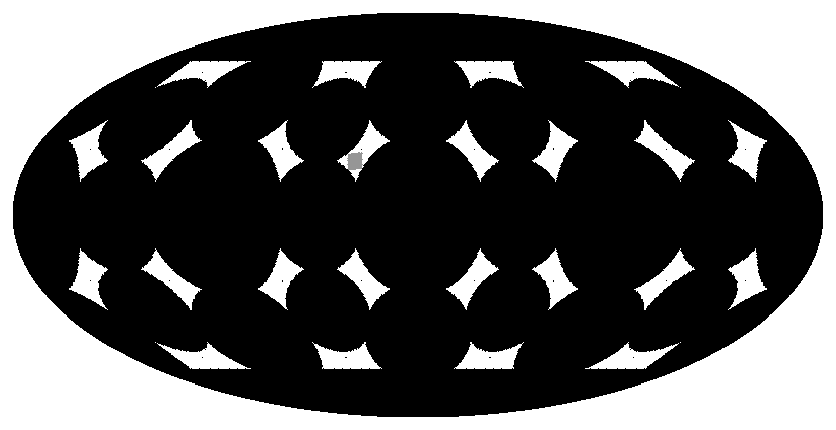

In [35]:
# C4
plotregion((0.63, -np.pi/2), 0.6, 0)

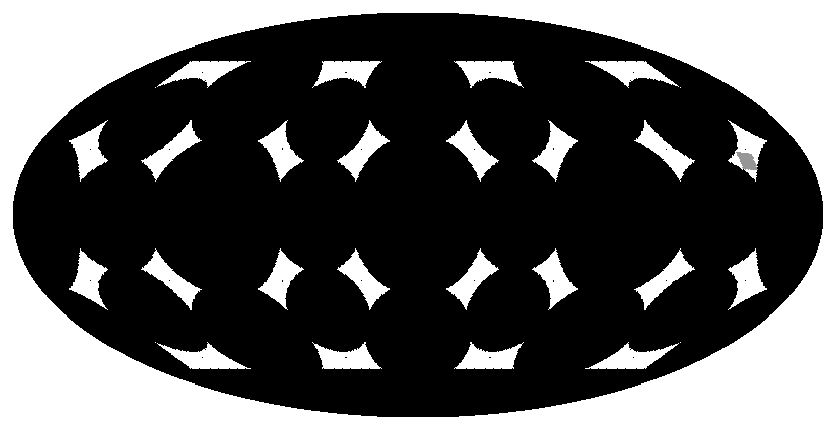

In [36]:
# C8
plotregion((0.63, np.pi/2), -0.6, -2.14)

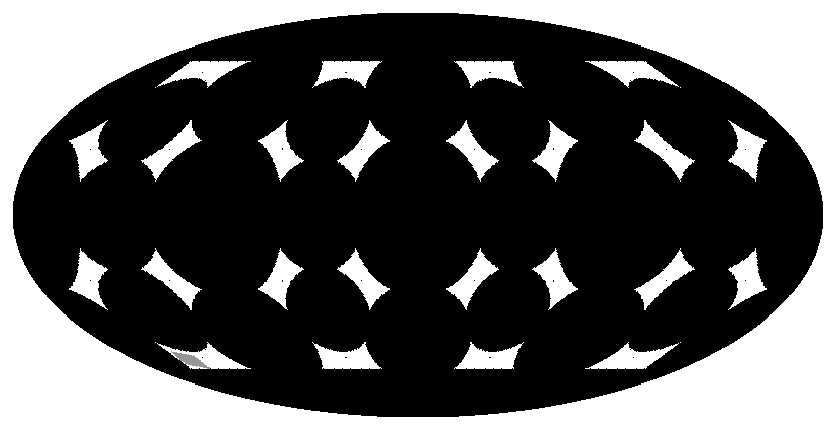

In [37]:
plotregion((1.18, np.pi/2), 1.11, 1.88) # reflect A1 to get F1

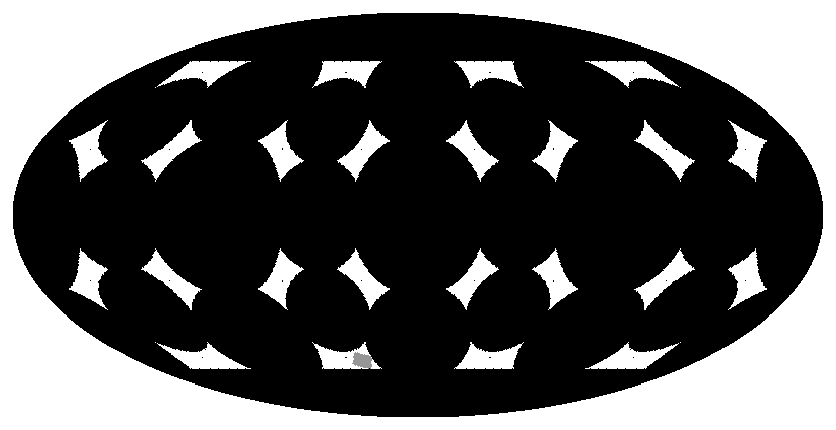

In [38]:
plotregion((1.2, np.pi/2), 1.1, 0)

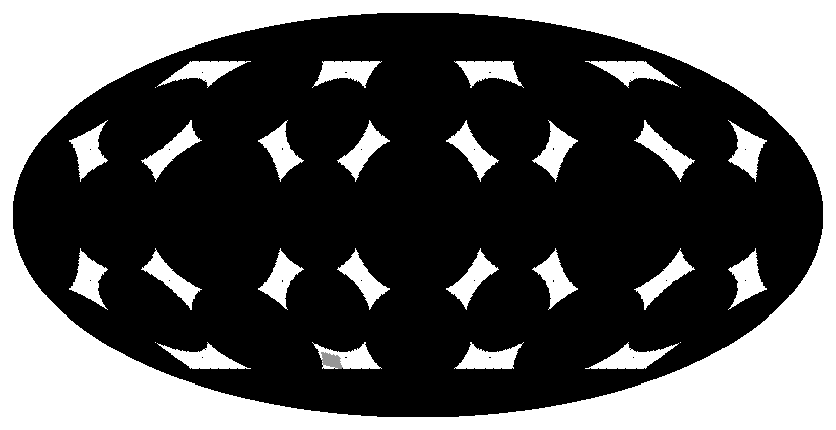

In [39]:
plotregion((1.2, np.pi/2), 1.1, 0.35)

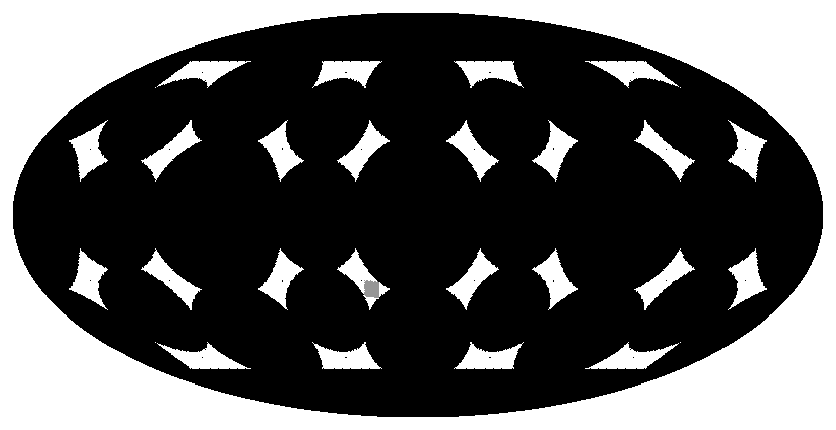

In [40]:
plotregion((0.94, np.pi/2), 0.6, 0)

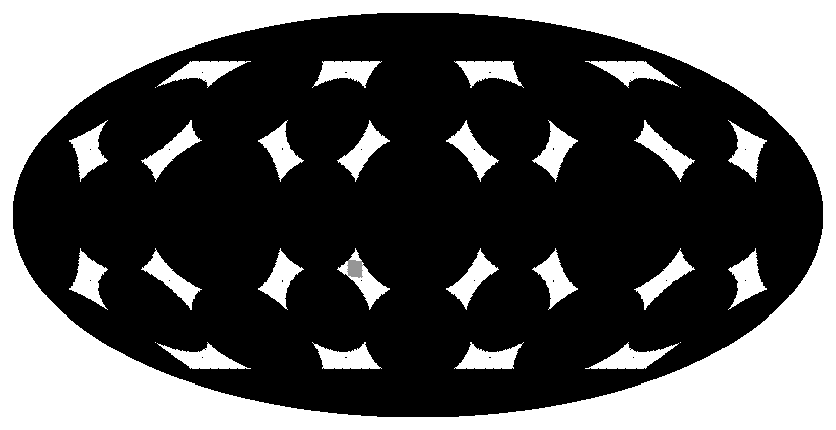

In [41]:
plotregion((0.63, np.pi/2), 0.6, 0)

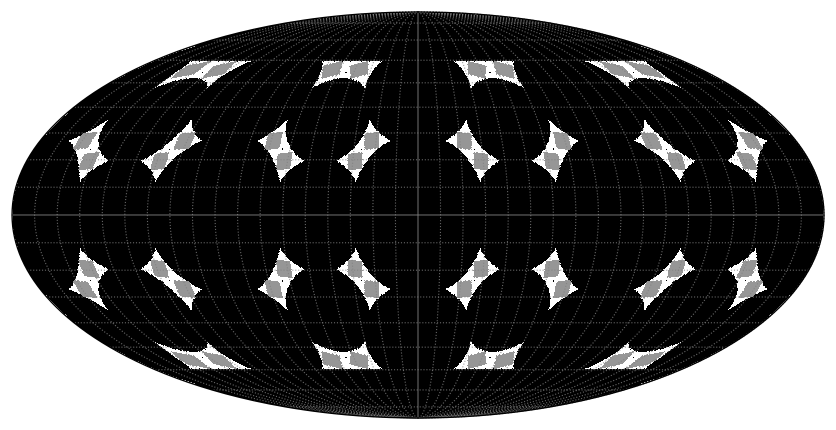

In [24]:
# I've now recorded all the regions in illustris_frb/regions.py, so let's plot all of them

from illustris_frb.regions import regions

regionpix = goodpix_1_z04 * goodpix_2 # good pixels found previously

for regname in regions.keys():
    reg = region(**regions[regname])

    centers = np.arange(-reg.size/2+reg.res/2, reg.size/2, reg.res) 
    thetas_, phis_ = np.meshgrid(np.pi/2 + centers, centers)
    thetas, phis = reg.rotate(thetas_.T.flatten(), phis_.T.flatten())
    
    ipix = np.unique(hp.ang2pix(nside, thetas, phis))
    regionpix[ ipix ] = 0.5

hp.mollview(regionpix, title=None, cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.8, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allregions.pdf'), dpi=250, bbox_inches='tight')

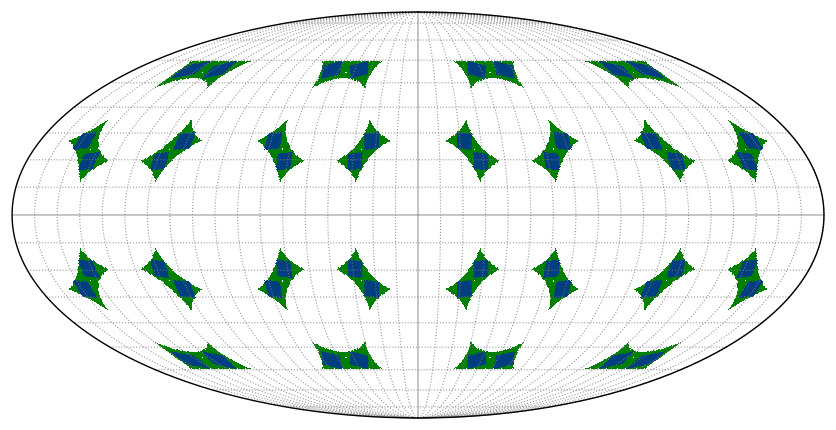

In [25]:
hp.mollview(regionpix, title=None, cmap=plt.colormaps['ocean'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.8, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allregions_color.pdf'), dpi=250, bbox_inches='tight')